In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
# Load Synthetic Data

gaussian_copula = pd.read_csv('Synthetic_data(Gaussian Copula).csv', index_col=False)
gaussian_copula = gaussian_copula.iloc[:,1:]

copula_gan = pd.read_csv('Synthetic_data(Copula GAN).csv', index_col=False)
copula_gan = copula_gan.iloc[:,1:]

ctgan = pd.read_csv('Synthetic_data(CTGAN).csv', index_col=False)
ctgan = ctgan.iloc[:,1:]

tave = pd.read_csv('Synthetic_data(TAVE).csv', index_col=False)
tave = tave.iloc[:,1:]


# Load Train Data
x_df = pd.read_csv('x_df.csv')
x_df = x_df.iloc[:, 1:]

# Load Label Data
y_df_binarized = np.load('y_df_binarized.npy')

# Combined df
full_df = x_df
full_df['dna'] = y_df_binarized

In [4]:
# Data_processing Module
def datasize_check(data, name):
    '''
    Data Size Checking

    Return : data shape and class distribution
    '''
    print(f'Data shape of {name}: {data.shape}')
    print(f'Class Distribution : {Counter(data["dna"])}\n')

def making_valid_data(data, number):
    '''
    60 validation dataset 

    Return Validation data
    '''
    df_0 = data[data['dna'] == 0].sample(number, random_state=42)
    df_1 = data[data['dna'] == 1].sample(number, random_state=42)

    result = pd.concat([df_0, df_1])

    train = data.drop(result.index)

    return train, result

def prepare_vis_com_data(data, synthetic):


    data = data.copy()
    synthetic = synthetic.copy()
    
    data['source'] = "Real"
    synthetic['source'] = "Synthetic"
    combined = pd.concat([data, synthetic], axis=0)
    
    features = combined.drop(columns=['dna', 'source'])
    labels = combined['source']
    
    return features, labels

def break_imbal(synthetic):
    synthetic_1 = synthetic[synthetic['dna'] == 1]

    return synthetic_1

# Model Training Module
def data_split(data, target, size):
    '''
    Train test Data Split

    Return:
    train & test data
    '''
    x_df = data.drop(columns=target)
    y_df = data[target]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, stratify=y_df, test_size=size, random_state=42)

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    print(f'Train Target Count: {Counter(y_train)}')
    print(f'Test Target Count: {Counter(y_test)}')

    return X_train, X_test, y_train, y_test

def ML_train(X_train, X_test, y_train, y_test, model_name):

    '''
    Machine Learning for   SVM , Logistic, SGD, LGBM

    Return:

    '''

    if model_name == 'SVM':
        
        # Class weight Setting
        class_weight = {0: 2, 1: 1.7}

        # SVM Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
        }

        # SVM Model Setting
        model = SVC(random_state=42, class_weight=class_weight)


    elif model_name == 'Logistic':
        # Class weight Setting
        class_weight = {0: 1, 1: 1}

        # Logistic Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'penalty' : ['l1', 'l2']
        }

        # Logistic Model Setting
        model = LogisticRegression(random_state=42, class_weight=class_weight)

    elif model_name == 'SGD':
        # Class weight Setting
        class_weight = {0: 2, 1: 3}

        # SGD Parmeter Setting
        param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty' : ['l1', 'l2']
        }
        # SGD Model Setting
        model = SGDClassifier(random_state=42, class_weight=class_weight)

    elif model_name == 'LGBM':
        # LightGBM Parameter Setting
        param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
        }
        # LightGBM Model Setting
        model = LGBMClassifier(random_state=42, scale_pos_weight=3) 

    else:
        print('Check Model Name.')




    # Best Parameter Searching
    result = {}

    # Stratified K-Fold Setting
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Training {model_name}...\n")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc_ovr', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Parameters & 5 Fold-cross validation
    cv_results = grid_search.cv_results_

    fold_f1_scores = []
    for i in range(5):
        print(f'Fold {i+1} Training ................\n')

    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)

    # Prediction with best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # AUC ROC Calculation
    if model_name == 'LGBM':
        auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    else:
        auc_roc = roc_auc_score(y_test, best_model.decision_function(X_test))

    # Assessment score present
    print(f"\nTest Result for {model_name}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Generate classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store result 
    result[model_name] = {
        'f1_score': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    }

    # Final Results Reporting
    print(f"\n{model_name} Test Results:")
    print(f"{model_name} F1-score : {result[model_name]['f1_score']: .4f}, AUC ROC : {auc_roc:.4f}, Accuracy : {result[model_name]['accuracy']:.4f}")

    return best_model, result
 
def val_result(data, model):
    y_pred = model.predict(data.drop(columns='dna'))
    print(classification_report(data['dna'], y_pred))
    result = classification_report(data['dna'], y_pred, output_dict=True)

    report_df = pd.DataFrame(result).transpose()

    model_name = model.__class__.__name__
    report_df.to_excel(f'{model_name}_classification_result.xlsx')
    
    return report_df



# Visualization module

def vis_bar(results, model_names):

    metrics = ['Accuracy', 'Weighted F1-Score']
    data = []

    for result, name in zip(results, model_names):
        accuracy = result.loc['accuracy', 'precision']
        weighted_f1 = result.loc['weighted avg', 'f1-score']
        data.append([name, accuracy, weighted_f1])

    plot_df = pd.DataFrame(data, columns=["Model", "Accuracy", "Weighted F1-Score"])


    ax = plot_df.set_index('Model').plot(kind='bar', figsize=(8, 6))
    plt.title('Comparison of Model Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(title="Metrics")

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def visualize_dim_reduction(data, labels, method='pca', random_state=42, **kwargs):
    
    if method.lower() == 'pca':
        reducer = PCA(n_components=2, **kwargs)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=random_state, **kwargs)
    else:
        raise ValueError('Invalid method. Choose from "pca", "tsne", "umap"')
    

    reduced_data = reducer.fit_transform(data)

    # Visualization
    sns.set_theme(style='darkgrid')

    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    ilabels = ['idr-0080', 'cpg-0012']

    palette = sns.color_palette('tab10', len(unique_labels))
    colors = [(0.5, 0.0, 0.5, 1.0), (1.0, 0.85, 0.0, 0.2)]  

    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(reduced_data[idx, 1], reduced_data[idx, 0], label=ilabels[i],
                    s=10, c=colors[i])
        
    
    plt.title(f'{method.upper()} Visualization', fontsize=16, fontweight='bold')
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.legend(loc="best", fontsize=12, frameon=True, edgecolor='black', shadow=False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [13]:
# Modification 
def visualize_dim_reduction(data, labels, method='pca', random_state=42, **kwargs):
    
    if method.lower() == 'pca':
        reducer = PCA(n_components=2, **kwargs)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=random_state, **kwargs)
    else:
        raise ValueError('Invalid method. Choose from "pca", "tsne", "umap"')

    reduced_data = reducer.fit_transform(data)

    # Visualization
    #sns.set_theme(style='darkgrid')

    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    ilabels = ['cpg-0012', 'idr-0080']

    
    colors = ['#7B1FA2', '#FFCC00']  

    
    idx_yellow = labels == unique_labels[0]  # cpg-0012
    plt.scatter(reduced_data[idx_yellow, 0], reduced_data[idx_yellow, 1], 
                label=ilabels[1], 
                s=20, c=[colors[1]], 
                alpha=0.5,  
                zorder=2)

    
    idx_purple = labels == unique_labels[1]  # idr-0080
    plt.scatter(reduced_data[idx_purple, 0], reduced_data[idx_purple, 1], 
                label=ilabels[0], 
                s=20, c=[colors[0]], 
                zorder=1)  

    #plt.title(f'{method.upper()} Visualization', fontsize=16, fontweight='bold')
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.legend(loc="best", fontsize=12, frameon=False, edgecolor='black', shadow=False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid(False, linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


In [6]:
# Data Size Chekcing
datasize_check(gaussian_copula, 'Gaussian_Copula')
datasize_check(copula_gan, 'Copula_GAN')
datasize_check(ctgan, 'CTGAN')
datasize_check(tave, 'TAVE')
datasize_check(full_df, 'Training Data')

Data shape of Gaussian_Copula: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of Copula_GAN: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of CTGAN: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of TAVE: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of Training Data: (357, 737)
Class Distribution : Counter({0: 306, 1: 51})



In [7]:
cpg = pd.read_csv('x_val_df.csv').iloc[:, 1:]

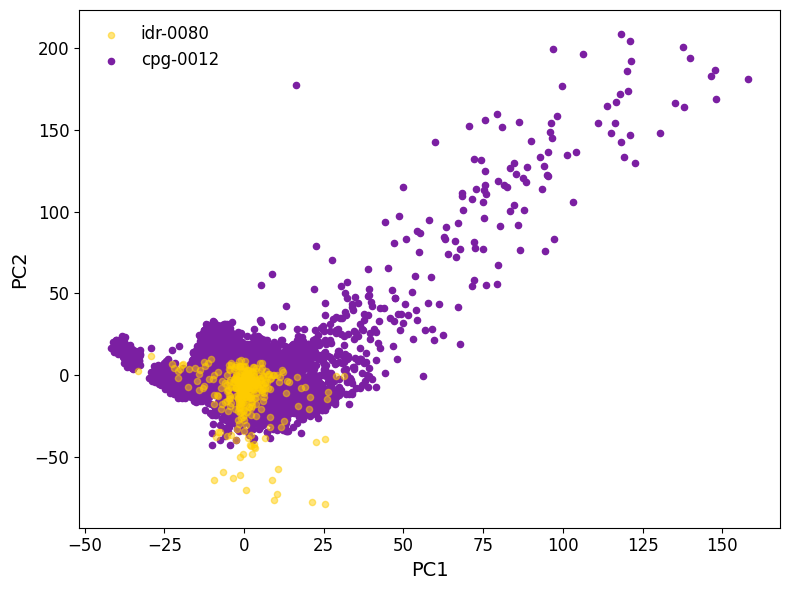

In [14]:
# Check Batch Effect
features, labels = prepare_vis_com_data(full_df, cpg)

visualize_dim_reduction(features, labels, method='pca')